### CAP 6640 
### Project 2 - Fake News Detection
### Mar 28, 2024

### Group 4
### Andres Graterol
###                   UCF ID: 4031393
### Zachary Lyons
###                   UCF ID: 4226832
### Christopher Hinkle
###                   UCF ID: 4038573
### Nicolas Leocadio
###                   UCF ID: 3791733

#### Imports

In [1]:
# Import everything we want up front
import re
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import itertools

from multiprocessing import Pool

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Download necessary resources from nltk
try:
    nltk.data.find('stopwords')
except LookupError:
    nltk.download('stopwords')
    
try:
    nltk.data.find('punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet') 

2024-03-27 21:59:12.416998: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 21:59:12.470672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 21:59:13.253880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/nick_/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/nick_/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloa

#### Step 1 - Data Collection

In [2]:
# Read in the training dataset as a dataframe
# Dataset is from the Kaggle Fake News competition
# https://www.kaggle.com/c/fake-news/data?select=train.csv
df = pd.read_csv('train.csv')

#### Step 2 - Data Preprocessing

In [3]:
# Drop NaN rows from the dataframe to avoid errors
df = df.dropna(how='all', axis=0)

# Merge the author, title, and text into a single column
df['article'] = df['author'] + ' ' + df['title'] + ' ' + df['text']

# Seclude the labels
# 1 - unreliable
# 0 - reliable
labels = df['label']

In [4]:
# For each article (author + title + text) in the dataframe, clean the text
lemmatizer = WordNetLemmatizer()

cleaned_corpus = []
stopword_set = set(stopwords.words('english'))

def clean_article(article: list) -> list:
    # Remove any non-alphanumeric characters
    cleaned_article = re.sub('[^a-zA-Z0-9 ]', '', str(article))
    # Lowercase the text & split into individual words
    cleaned_article = cleaned_article.lower().split()
    # Lemmatize the words and remove any stopwords
    cleaned_article = [lemmatizer.lemmatize(word) for word in cleaned_article if not word in stopword_set]
    # Join the words back together
    return ' '.join(cleaned_article)

# Pandas has a df.apply() function that is being exploited here, which applies the 
# clean_article function above to each row of the dataframe
#
# Then Pool().map() just multithreads the process
# This is down to ~8s on my PC - Nick
with Pool() as p:
    cleaned_corpus = p.map(clean_article, df['article'])

In [5]:
# Drop the lables for empy articles
labels = df[list(map(lambda x: len(x) > 0, cleaned_corpus))]
labels = labels['label']

In [6]:
# Remove these empty articles from the corpus 
cleaned_corpus = [i for i in cleaned_corpus if i]
len(cleaned_corpus)

20800

#### Step 3 - Feature Engineering

In [10]:
# Tokenize the cleaned text, using "<OOV>" for words outside the vocabulary
tokenizer = Tokenizer(num_words=25000, oov_token='<OOV>')
tokenizer.fit_on_texts(cleaned_corpus)

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(cleaned_corpus)

# Get the number of unique words
num_unique_words = len(tokenizer.word_index)
# There were about 170,000 words in the corpus, so we picked the top 25,000

In [11]:
# Pad sentences with zeroes at the start to make them all the same length
embedded_docs = pad_sequences(sequences, padding='pre', maxlen=500)

#### Step 4 - Algorithm and Results

In [12]:
# Increase the number of embedding dimensions
embedding_vector_features = 100

model = Sequential()
model.add(Embedding(num_unique_words, embedding_vector_features))
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01))) # Add regularization
model.add(Dropout(0.5))
model.add(LSTM(100)) # Add another LSTM layer
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2024-03-27 21:59:47.968126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 21:59:48.093597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 21:59:48.093899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 21:59:48.095486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-27 21:59:48.095877: I external/local_xla/xla/stream_executor

In [14]:
# Convert data & labels to numpy arrays so we can easily split them
X = np.array(embedded_docs)
Y = np.array(labels)

# Train & Test Split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [15]:
# List available devices for tensorflow to see if we are using GPU
print("Num GPUs Available: ", tf.config.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# Add early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(patience=4, mode='min', restore_best_weights=True)

# Train da model or load a previous one
# Training took about 4min 10seconds on RTX 3090, similar but slightly longer on i7 13700k due to the use of dropout & early stopping
# Training time varies drastically with the tokenizer's num_words parameter as well as the maxlen parameter of the pad_sequences function

# Train
model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=20, callbacks=[callback])

# Load
# model = tf.keras.models.load_model('model.keras')

Epoch 1/100


2024-03-27 21:59:51.496105: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


510/510 ━━━━━━━━━━━━━━━━━━━━ 38s 70ms/step - accuracy: 0.8368 - loss: 0.7333 - val_accuracy: 0.7245 - val_loss: 0.6219
Epoch 2/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.9333 - loss: 0.2144 - val_accuracy: 0.9391 - val_loss: 0.2573
Epoch 3/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.9826 - loss: 0.1132 - val_accuracy: 0.9412 - val_loss: 0.1953
Epoch 4/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.9911 - loss: 0.0553 - val_accuracy: 0.9268 - val_loss: 0.2267
Epoch 5/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9957 - loss: 0.0404 - val_accuracy: 0.9402 - val_loss: 0.2297
Epoch 6/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9947 - loss: 0.0301 - val_accuracy: 0.9369 - val_loss: 0.2367
Epoch 7/100
510/510 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.9971 - loss: 0.0215 - val_accuracy: 0.9321 - val_loss: 0.2378


In [17]:
# Save da model
model.save('model.keras')

#### Step 5 - Evaluation 

137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step
[1 0 1 ... 0 1 1]
[[9.9500728e-01]
 [6.1659474e-04]
 [9.9225992e-01]
 ...
 [9.8863977e-04]
 [9.9382049e-01]
 [7.6614790e-02]]


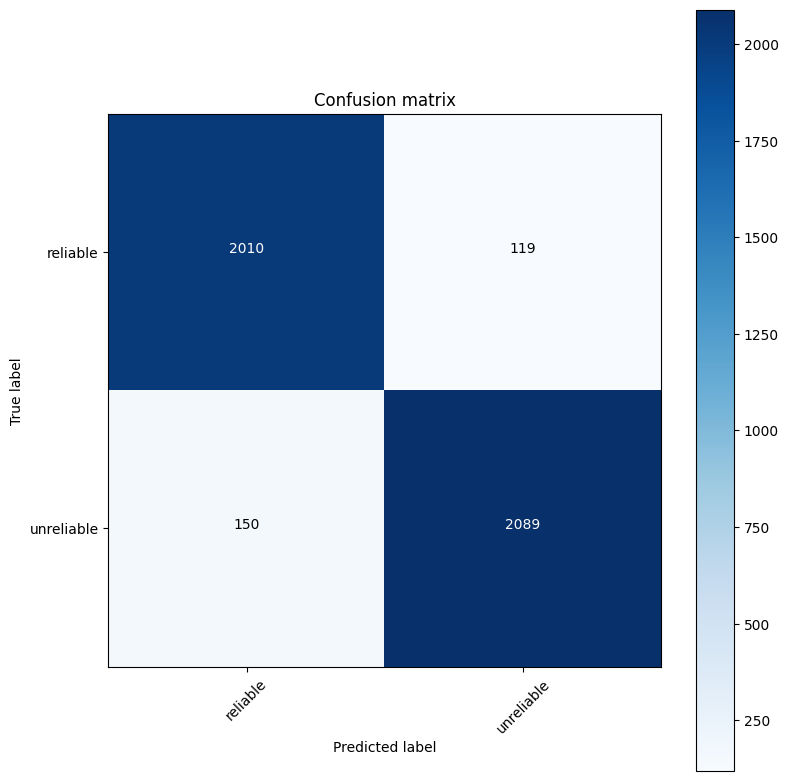

In [18]:
# Generate predictions on the test set based on the generated model
y_pred = model.predict(X_test)

print(y_test)
print(y_pred)

cm = confusion_matrix(y_test, y_pred.round())

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, ['reliable', 'unreliable'])


In [19]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred.round())
print(accuracy)

# Classification Report
classification_report = classification_report(y_test, y_pred.round())
print(classification_report)

0.9384157509157509
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2129
           1       0.95      0.93      0.94      2239

    accuracy                           0.94      4368
   macro avg       0.94      0.94      0.94      4368
weighted avg       0.94      0.94      0.94      4368

